In [30]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal

from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace

from scipy.linalg import sqrtm,inv

In [31]:
# generate an image from a non-flat power spectrum
n = 50
dtheta_amin = 3.
dtheta_rad = dtheta_amin/60*pi/180

lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
lxgrid,lygrid = meshgrid(lvals,lvals)
lmaggrid = sqrt(lxgrid**2+lygrid**2)

img_ft = (random.randn(n,n)+1j*np.random.randn(n,n))*1./(1+lmaggrid)
img = np.real(fft.ifft2(img_ft)) # taking the real part enforces conjugate symmetry in fourier space

mask = random.randn(n,n)>-.8

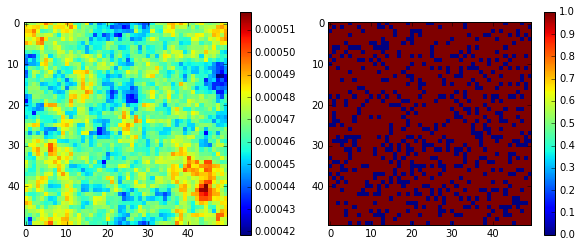

In [32]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(img,interpolation='nearest')
plt.colorbar()

plt.subplot(122)
plt.imshow(mask,interpolation='nearest')
plt.colorbar()

In [33]:
# computer FFT-based power spectra

# lmin,lmax = 300,5000
lmin,lmax = 150,5000
uselogbins = True
nbins = 20
img_meas = img*mask

In [34]:
def make_bins(lmin,lmax,nbins,uselogbins):
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    return lbincenters,lbinedges

lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins=uselogbins)
    
lvals = fft.fftfreq(n)*2*pi/dtheta_rad # ell values
lxgrid,lygrid = meshgrid(lvals,lvals)
lmaggrid = sqrt(lxgrid**2+lygrid**2)

thvals = (arange(n)-n/2)*dtheta_rad # theta values
thxgrid,thygrid = meshgrid(thvals,thvals)

In [35]:
xir = matrix(img_meas.flatten()).T

In [36]:
# put in a guess of the data covariance

Cguess_ft = 2*matrix(np.diag(1./(1+lmaggrid.flatten())**2))

In [40]:
# generate the fourier transform matrix

lxvals,thxvals = meshgrid(lxgrid.flatten(),thxgrid.flatten()) # ell_x and theta_x
lyvals,thyvals = meshgrid(lygrid.flatten(),thygrid.flatten()) # ell_y and theta_y
F = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))/n**2

In [41]:
# make C^{-1}, taking into account the data covariance and pixel masking 

Csignal = F*Cguess_ft*conj(F).T
Cmask = 1.e6*np.matrix(np.diag(img_meas.flatten()==0)) # IS THIS A REASONABLE NUMBER ??
Cinv = inv(Csignal + Cmask)

# 18 sec

In [83]:
# see https://www.evernote.com/shard/s316/nl/2147483647/64925924-5e74-49fa-87a4-f792901ef6cb/

Fbar = F[img_meas.flatten()==0,:]
print('a')
FP = F - F*conj(Fbar.T)*inv(Fbar*conj(Fbar.T))*Fbar
print('b')
Cinv_pseudo = FP*inv(Cguess_ft+conj(Fbar.T)*Fbar)*conj(FP.T)

# 26 sec

a
b


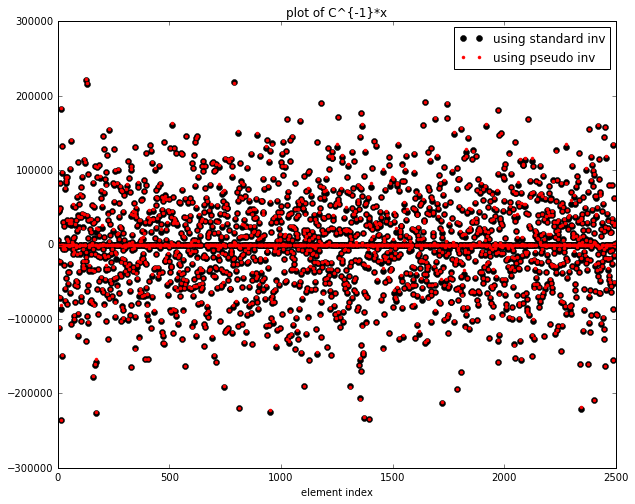

In [84]:
plt.figure(figsize=(10,8))
plt.plot(np.real(Cinv*xir),'ko',label='using standard inv')
plt.plot(n**4*np.real(Cinv_pseudo*xir),'r.',label='using pseudo inv')

plt.title('plot of C^{-1}*x')
plt.legend()
plt.xlabel('element index')